<a href="https://www.kaggle.com/code/franciscangeno/anomaly-detection?scriptVersionId=113875356" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anomaly-detection-algorithm/ex8data1.mat


In [2]:
df = loadmat("/kaggle/input/anomaly-detection-algorithm/ex8data1.mat")

In [3]:
# access the X element from the dictionary
df = df["X"]

In [4]:
# convert the array to a pandas dataframe
df=pd.DataFrame(df)

In [5]:
df

,0,1
0,13.046815,14.741152
1,13.408520,13.763270
2,14.195915,15.853181
3,14.914701,16.174260
4,13.576700,14.042849
...,...,...
302,12.476629,14.459370
303,19.582573,10.411619
304,23.339868,16.298874
305,18.261188,17.978309


In [6]:
df.describe()

,0,1
count,307.000000,307.000000
mean,14.112226,14.997711
std,1.355957,1.309707
min,4.752613,4.126232
25%,13.403351,14.361997
50%,14.059507,15.023113
75%,14.675503,15.654394
max,23.339868,24.350407


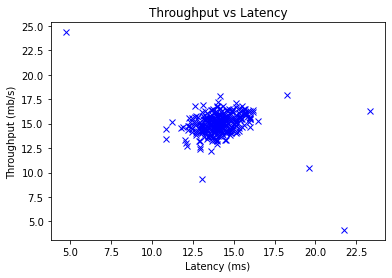

In [7]:
n_training_samples = df.shape[0]
n_dim = df.shape[1]

plt.figure(1)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.title('Throughput vs Latency')
plt.plot(df.iloc[:,0],df.iloc[:,1],"bx")
plt.show()

In [8]:
# # feature normalization
# def feature_normalize(df):
#     mu = np.mean(df,axis=0)
#     sigma = np.std(df,axis=0)
#     return (df - mu)/sigma
# # estimate the gaussian distribution 
# def estimateGaussian(df):
#     mu = np.mean(df, axis=0)
#     sigma = np.cov(df.T)
#     return mu, sigma
# # multivariate
# def multivariateGaussian(df,mu,sigma):
#     p = multivariate_normal(mean=mu, cov=sigma)
#     return p.pdf(dataset)

In [9]:
# split the data into train,test and validation set
train,  test, validation = np.split(df.sample(frac=1), [int(.8*len(df)),int(.9*len(df))])

In [10]:
train.shape, validation.shape, test.shape

((245, 2), (31, 2), (31, 2))

In [11]:
train=np.array(train).astype("float")
validation=np.array(validation).astype("float")
test=np.array(test).astype("float")

In [12]:
np.ravel(train)
np.ravel(validation)
np.ravel(test)

array([13.5505769 , 15.73044061, 23.33986753, 16.29887355, 13.61173302,
       14.86806414, 13.63292363, 13.62886894, 15.67636615, 15.89169137,
       13.74951531, 15.26803136, 13.66602494, 16.44517365, 14.30044704,
       15.26643299, 15.6350487 , 16.49094477, 13.5491294 , 15.53827677,
       18.26118844, 17.978309  , 13.13166385, 15.79882584, 13.11971434,
       14.66081846, 13.96984547, 16.17341605, 13.85758878, 15.03526838,
       14.01648222, 14.33509982, 13.87130103, 14.97399469, 14.96982662,
       15.59222553, 13.04681517, 14.74115241, 15.66145055, 14.81146451,
       13.0342773 , 14.25689091, 12.87853442, 13.2017448 , 14.21251759,
       15.08270517, 13.968568  , 13.19821237, 14.22694439, 14.34798436,
       14.36799225, 16.75782354, 15.99450697, 15.45329383, 15.31499528,
       14.56835428, 14.96991942, 16.51830493, 14.53717523, 14.24224248,
       14.80103055, 13.8181314 ])

Next is for us to define a function ,ϵ, that will help us get the optimal value for the threshold which will be used to separate the normal and the anomalous datapoints. We are going to make use of the cross validation dataset to learn the optimal values of ϵ. To achieve this, we are going to try different values in a range of learned probabilities. We will then calculate the f1-score for the predicted anomalies based on the ground truth available data. The ϵ with the highest value of f1-score will be our threshold. This means that the probability that lies below the selected threshold will be considered anomalous.

In [13]:
# # feature normalization
# def feature_normalize(df):
#     mu = np.mean(df,axis=0)
#     sigma = np.std(df,axis=0)
#     return (df - mu)/sigma
# # estimate the gaussian distribution 
# def estimate_gaussian(df):
#     mu = np.mean(df, axis=0)
#     sigma = np.cov(df.T)
#     return mu, sigma
# # multivariate
# def multivariate_gaussian(df,mu,sigma):
#     p = multivariate_normal(mean=mu, cov=sigma)
#     return p.pdf(df)
# def select_threshold(probs, test):
#     best_epsilon = 0
#     best_f1 = 0
#     f = 0
#     stepsize = (max(probs) - min(probs)) / 1000;
#     epsilons = np.arange(min(probs), max(probs), stepsize)
#     for epsilon in np.nditer(epsilons):
#         predictions = (probs < epsilon)
#         f = f1_score(test, predictions, average='binary')
#         if f > best_f1:
#             best_f1 = f
#             best_epsilon = epsilon

#     return best_f1, best_epsilon

# mu, sigma = estimate_gaussian(train)
# p = multivariate_gaussian(train,mu,sigma)

# #selecting optimal value of epsilon using cross validation
# p_cv = multivariate_gaussian(validation,mu,sigma)
# fscore, ep = select_threshold(p_cv,test)
# print(fscore, ep)

# #selecting outlier datapoints
# outliers = np.asarray(np.where(p < ep))